# Selecting detector modes in METIS

This notebook demonstrates the effect `detector_readout_parameters`, which selects between the different detector readout modes. These are `fast` and `slow` for the HAWAII2RG detectors, and `high_capacity` and `low_capacity` for the Geosnap detector.

In [1]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out.
sim.link_irdb("../../../../")

Python:
3.10.18 (main, Jun  5 2025, 13:08:10) [GCC 11.2.0]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.3.3
             astropy: 6.1.7
      beautifulsoup4: 4.13.4
            docutils: 0.19
               httpx: 0.28.1
                lxml: 5.4.0
          matplotlib: 3.10.5
      more-itertools: 10.7.0
               numpy: 1.26.4
           packaging: 25.0
               pooch: 1.8.2
              pyyaml: 6.0.2
               scipy: 1.15.3
            scopesim: 0.10.0
       scopesim_data: could not be loaded.
  scopesim_templates: could not be loaded.
         skycalc-ipy: 0.5.3
             synphot: 1.6.0
                tqdm: 4.67.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2025-06-30
      METIS: 2025-06-30

Operating System info:
   System: Linux
  Release: 6.12.13-200.fc41.aarch64
  Version: #1 SMP PREEMPT_DYNAMIC Sat Feb  8 20:30:50 UTC 2025
  Machine: aarch64


If you haven't got the instrument packages yet, uncomment the following cell.

In [ ]:
# sim.download_packages(["METIS", "ELT", "Armazones"])

In [2]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["img_lm"])

The default readout mode for `img_lm` is the fast mode:

In [3]:
cmd["!OBS.detector_readout_mode"]

'fast'

We build the optical train using the default mode, and then check that the relevant parameters (`mindit`, `full_well`, `readout_noise` and `dark_current`) are taken over correctly, first in the `cmds` property of the optical train, then - most importantly - into the parameters of the affected `Effect` objects (demonstrated for the `readout_noise` effect).

In [4]:
metis = sim.OpticalTrain(cmd)

In [5]:
metis.cmds["!DET"]

[1] mapping contents:
├─layout:
│ └─file_name: FPA_metis_img_lm_layout.dat
├─qe_curve:
│ └─file_name: QE_detector_H2RG_METIS.dat
├─linearity:
│ └─file_name: FPA_linearity_HxRG.dat
├─detector: HAWAII2RG
├─image_plane_id: 0
├─temperature: -230
├─dit: !OBS.dit
├─ndit: !OBS.ndit
├─mode: fast
├─mindit: 0.04
├─full_well: 100000.0
├─gain: 4.0
├─readout_noise: 70
└─dark_current: 0.05

In [6]:
metis['readout_noise'].meta['noise_std']

'!DET.readout_noise'

The "bang string" here means that the value is taken from the `cmds` structure in the previous cell, i.e.

In [7]:
metis.cmds[metis['readout_noise'].meta['noise_std']]

70

At this stage, we have access to the available detector modes and the parameter values that are set by them:

In [8]:
print(metis['detector_readout_parameters'].list_modes())

fast:
  description: HAWAII2RG, fast mode
  !DET.mode: fast
  !DET.mindit: 0.04
  !DET.full_well: 100000.0
  !DET.gain: 4.0
  !DET.readout_noise: 70
  !DET.dark_current: 0.05
slow:
  description: HAWAII2RG, slow mode
  !DET.mode: slow
  !DET.mindit: 1.3
  !DET.full_well: 100000.0
  !DET.gain: 2.5
  !DET.readout_noise: 15
  !DET.dark_current: 0.05



We can switch to the `slow` mode in the existing optical train by doing

In [9]:
metis.cmds["!OBS.detector_readout_mode"] = "slow"
metis.update()

In [10]:
metis.cmds["!DET"]

[1] mapping contents:
├─layout:
│ └─file_name: FPA_metis_img_lm_layout.dat
├─qe_curve:
│ └─file_name: QE_detector_H2RG_METIS.dat
├─linearity:
│ └─file_name: FPA_linearity_HxRG.dat
├─detector: HAWAII2RG
├─image_plane_id: 0
├─temperature: -230
├─dit: !OBS.dit
├─ndit: !OBS.ndit
├─mode: slow
├─mindit: 1.3
├─full_well: 100000.0
├─gain: 2.5
├─readout_noise: 15
└─dark_current: 0.05

In [11]:
metis.cmds[metis['readout_noise'].meta['noise_std']]

15

# Test: detector noise level (LSS-L)

To investigate the behaviour of the detector readout modes, we look at the L-band long-slit mode where the areas of the detector outside the spectral trace contain only readout noise and dark current. The default mode for long-slit spectroscopy is the `slow` mode, and we'll switch to the `fast` mode afterwards.

In [12]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"])
metis = sim.OpticalTrain(cmd)

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:163: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  fov = thetrace.fov_grid()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



In [13]:
print("Detector mode:", metis.cmds["!OBS.detector_readout_mode"])
metis['psf'].include = False     # not needed for blank-sky observations
metis.observe()
hdul_slow = metis.readout(exptime=1000)[0]

Detector mode: slow
py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.image_plane - No BUNIT found in added HDU.
astar.scopesim.effects.electronic - Requested exposure time: 1000.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 4.324 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 2.5
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effect

We get the statistics in a strip at the left edge of the detector that is not covered by any source or background flux and compare to the expected values.

In [14]:
ndit_slow = metis.cmds["!OBS.ndit"]
dit_slow = metis.cmds["!OBS.dit"]

bg_slow = hdul_slow[1].data[250:1750, 10:200].mean()
bg_slow_expected = dit_slow * ndit_slow * metis.cmds["!DET.dark_current"]

noise_slow = hdul_slow[1].data[250:1750, 10:200].std()
noise_slow_expected = np.sqrt(ndit_slow) * metis.cmds["!DET.readout_noise"]

Do the same for the `fast` mode.

In [15]:
hdul_fast = metis.readout(detector_readout_mode="fast", exptime=1000)[0]

astar.scopesim.effects.electronic - Requested exposure time: 1000.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 4.324 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s


In [16]:
ndit_fast = metis.cmds["!OBS.ndit"]
dit_fast = metis.cmds["!OBS.dit"]

bg_fast = hdul_fast[1].data[250:1750, 10:200].mean()
bg_fast_expected = dit_fast * ndit_fast * metis.cmds["!DET.dark_current"]

noise_fast = hdul_fast[1].data[250:1750, 10:200].std()
noise_fast_expected = np.sqrt(ndit_fast) * metis.cmds["!DET.readout_noise"]

In [17]:
print(f"""
Fast: ndit  = {ndit_fast}     dit = {dit_fast:.2f}
      bg    = {bg_fast:5.1f}   expected: {bg_fast_expected:5.1f}
      noise = {noise_fast:5.1f}  expected: {noise_fast_expected:5.1f}""")
print(f"""
Slow: ndit  = {ndit_slow}     dit = {dit_slow:.2f}
      bg    = {bg_slow:5.1f}   expected: {bg_slow_expected:5.1f}   
      noise = {noise_slow:5.1f}   expected: {noise_slow_expected:.1f}""")


Fast: ndit  = 232     dit = 4.31
      bg    =   0.1   expected:  50.0
      noise =   1.1  expected: 1066.2

Slow: ndit  = 232     dit = 4.31
      bg    =   0.1   expected:  50.0   
      noise =   0.4   expected: 228.5


Finally, we can let Scopesim automatically select the "best" mode.

In [18]:
hdul_auto = metis.readout(detector_readout_mode="auto", exptime=1000)[0]

astar.scopesim.effects.electronic - Detector mode set to slow
astar.scopesim.effects.electronic - Requested exposure time: 1000.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 4.324 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 2.5
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 4.310 s, NDIT = 232
astar.scopesim.effects.electronic - Total exposure time: 1000.000 s


The advantage of the "slow" mode of the H2RG detector is the low readout noise. The "fast" mode permit smaller DITs and would be selected for bright sources that would saturate the detector at the minimum DIT of the "slow" mode. 

# Test: Full well (IMG-N) 
This demonstrates the high- and low-capacity modes of the Geosnap detector. The setup uses a neutral-density filter to ensure that the background does not saturate the detector in the low-capacity mode. The source is a very bright star, which saturates in the low-capacity mode but does not in the high-capacity mode.

In [7]:
star = sim.source.source_templates.star(flux=20 * u.Jy)

cmd_n = sim.UserCommands(use_instrument="METIS", set_modes=['img_n'],
                        properties={"!OBS.filter_name": "N2", "!OBS.nd_filter_name": "ND_OD1"})
metis_n = sim.OpticalTrain(cmd_n)

In [8]:
metis_n.observe(star, update=True)
print("--- high-capacity mode ---")
hdul_high = metis_n.readout(detector_readout_mode="high_capacity", exptime=1)[0]
fullwell_high = metis_n.cmds["!DET.full_well"]
gain_high = metis_n.cmds["!DET.gain"]
ndit_high = metis_n.cmds["!OBS.ndit"]

print("--- low-capacity mode ---")
hdul_low = metis_n.readout(detector_readout_mode="low_capacity", exptime=1)[0]
fullwell_low = metis_n.cmds["!DET.full_well"]
gain_low = metis_n.cmds["!DET.gain"]
ndit_low = metis_n.cmds["!OBS.ndit"]

 FOVs:   0%|          | 0/3 [00:00<?, ?it/s]

--- high-capacity mode ---
astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.062 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.059 s, NDIT = 17
astar.scopesim.effects.electronic - Total exposure time: 1.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 201
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.059 s, NDIT = 17
astar.scopesim.effects.electronic - Total exposure time: 1.000 s
--- low-capacity mode ---
astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.004 s
astar.scopesim.effects.electronic - WARNING: DIT = 0.004 s < MINDIT = 0.011 s
astar.scopesim.effects.electronic - WARNING: The detector will likely be satura

We take the average over NDIT exposures (units: electrons per DIT) so that we can immediately compare the counts to the full wells for the two modes.

In [9]:
detimg_high = hdul_high[1].data * gain_high
detimg_low = hdul_low[1].data * gain_low

In [9]:
detimg_high = hdul_high[1].data * gain_high
detimg_low = hdul_low[1].data * gain_low

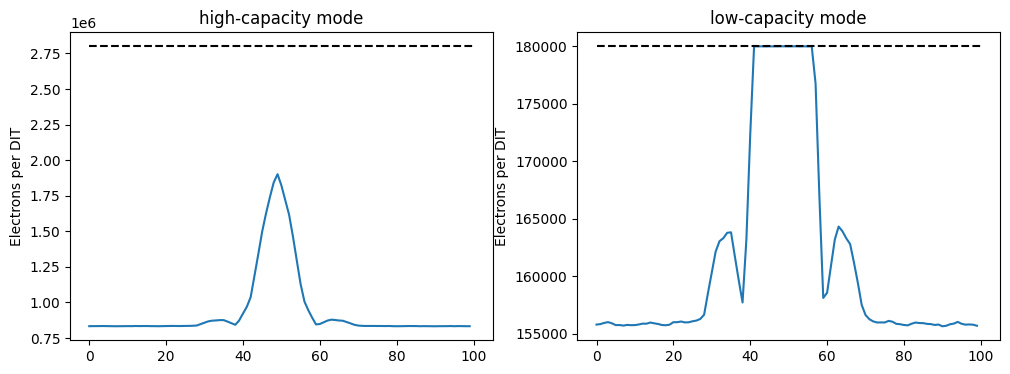

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(detimg_high[1024, 974:1074])
plt.title("high-capacity mode")
plt.hlines(fullwell_high, 0, 100, colors='k', linestyles='dashed')
plt.ylabel("Electrons per DIT")

plt.subplot(122)
plt.plot(detimg_low[1024, 974:1074])
plt.title(label="low-capacity mode")
plt.hlines(fullwell_low, 0, 100, colors='k', linestyles="dashed")
plt.ylabel("Electrons per DIT");

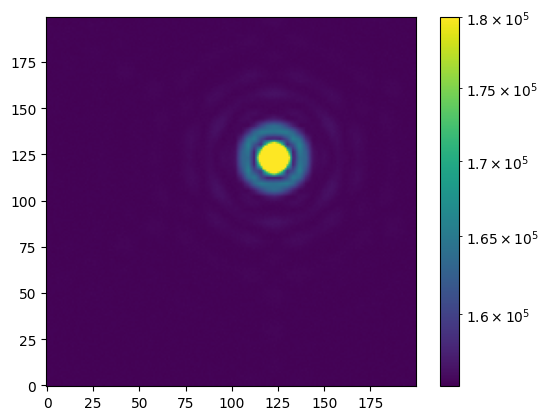

In [24]:
from matplotlib.colors import LogNorm

plt.imshow(detimg_low[900:1100,900:1100], norm=LogNorm(), origin='lower')
plt.colorbar()
plt.show()